In [2]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import os

data = 'balanced_05_vel05_pringles_amax_12_32/'
path = '/home/luiz/my_projects/crazyflie/crazyflie_controller/src/data/csv_data/' + data
save_image_path = '/home/luiz/my_projects/crazyflie/crazyflie_controller/src/data/images/' + data + 'kalman'

save_flag = True
cut_data = True

if not os.path.exists(save_image_path):
    os.makedirs(save_image_path)

### CSV's available
# control_ref.csv
# control_sent.csv
# desired_position.csv
# desired_velocity.csv
# orientation_optitrack.csv
# pitch_roll_crazyflie.csv
# position_gaussian_error.csv
# position_kalman.csv
# position_optitrack.csv
# reference_vel.csv
# thrust_crazyflie.csv
# time.csv
# vel_crazyflie.csv
# vel_kalmam.csv
# vel_optitrack.csv
# yaw_angle_crazyflie.csv
# z_crazyflie.csv

# Load the data from CSV files
time = os.path.join(path, 'time.csv')

### Position
desired_position_path = os.path.join(path, 'desired_position.csv')
position_optitrack_path = os.path.join(path, 'position_optitrack.csv')
position_kalman_path = os.path.join(path, 'position_kalman.csv')
position_gaussian_error_path = os.path.join(path, 'position_gaussian_error.csv')

### Velocity
desired_velocity_path = os.path.join(path, 'desired_velocity.csv')
vel_optitrack_path = os.path.join(path, 'vel_optitrack.csv')
vel_kalman_path = os.path.join(path, 'vel_kalmam.csv')
vel_crazyflie_path = os.path.join(path, 'vel_crazyflie.csv')

### Orientation
orientation_optitrack_path = os.path.join(path, 'orientation_optitrack.csv')
yaw_angle_crazyflie_path = os.path.join(path, 'yaw_angle_crazyflie.csv')

# Load the data from CSV files
time = pd.read_csv(time)
desired_position = pd.read_csv(desired_position_path)
position_optitrack = pd.read_csv(position_optitrack_path)
position_kalman = pd.read_csv(position_kalman_path)
position_gaussian_error = pd.read_csv(position_gaussian_error_path)
desired_velocity = pd.read_csv(desired_velocity_path)
vel_optitrack = pd.read_csv(vel_optitrack_path)
vel_kalman = pd.read_csv(vel_kalman_path)
vel_crazyflie = pd.read_csv(vel_crazyflie_path)

orientation_optitrack = pd.read_csv(orientation_optitrack_path)
yaw_crazyflie = pd.read_csv(yaw_angle_crazyflie_path)

# Tranforming the data into numpy arrays
time = time.values
desired_position = desired_position.values
position_optitrack = position_optitrack.values
position_kalman = position_kalman.values
position_gaussian_error = position_gaussian_error.values
desired_velocity = desired_velocity.values
vel_optitrack_world= vel_optitrack.values
vel_kalman_body = vel_kalman.values
vel_crazyflie_world = vel_crazyflie.values
orientation_optitrack = orientation_optitrack.values
yaw_crazyflie = np.deg2rad(yaw_crazyflie.values)

### Limit the data to a specific time
if cut_data:
    start = 5
    end = 55

    len_time = len(time)
    max_time = time[len_time-1]

    start_index = int(start*len_time/max_time)
    end_index = int(end*len_time/max_time)

    time = np.array(time[start_index:end_index])
    desired_position = np.array(desired_position[start_index:end_index])
    position_kalman = np.array(position_kalman[start_index:end_index])
    position_optitrack = np.array(position_optitrack[start_index:end_index])
    position_gaussian_error = np.array(position_gaussian_error[start_index:end_index])
    desired_velocity = np.array(desired_velocity[start_index:end_index])
    vel_optitrack_world = np.array(vel_optitrack_world[start_index:end_index])
    vel_kalman_body = np.array(vel_kalman_body[start_index:end_index])
    vel_crazyflie_world = np.array(vel_crazyflie_world[start_index:end_index])
    orientation_optitrack = np.array(orientation_optitrack[start_index:end_index])
    yaw_crazyflie = np.array(yaw_crazyflie[start_index:end_index])

In [3]:
def rotation_body_to_world(orientation, vector):
    R = np.array([[np.cos(orientation) , -np.sin(orientation)], 
                  [np.sin(orientation) , np.cos(orientation)]])
    return np.dot(R, vector)

def rotation_world_to_body(orientation, vector):
    R = np.array([[np.cos(orientation) , np.sin(orientation)], 
                  [-np.sin(orientation), np.cos(orientation)]])
    return np.dot(R, vector)

# Function to calculate RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))
    # return np.std(y_true - y_pred)

In [4]:
orientation_optitrack_rad = np.array([R.from_quat(orientation).as_euler('xyz', degrees=False) for orientation in orientation_optitrack])

vel_kalman_world = np.zeros((len(time), 3))
vel_optitrack_body = np.zeros((len(time), 3))
vel_crazyflie_body = np.zeros((len(time), 3))

for i in range(len(time)):
    vel_crazyflie_body[i, 0:2] = rotation_world_to_body(yaw_crazyflie[i,0], vel_crazyflie_world[i, 0:2])
    vel_crazyflie_body[i, 2] = vel_crazyflie_world[i, 2]

    vel_optitrack_body[i, 0:2] = rotation_world_to_body(orientation_optitrack_rad[i, 2], vel_optitrack_world[i, 0:2])
    vel_optitrack_body[i, 2] = vel_optitrack_world[i, 2]

    vel_kalman_world[i, 0:2] = rotation_body_to_world(yaw_crazyflie[i, 0], vel_kalman_body[i, 0:2])
    vel_kalman_world[i, 2] = vel_kalman_body[i, 2]

## Kalman vs Optitrack with gaussian error

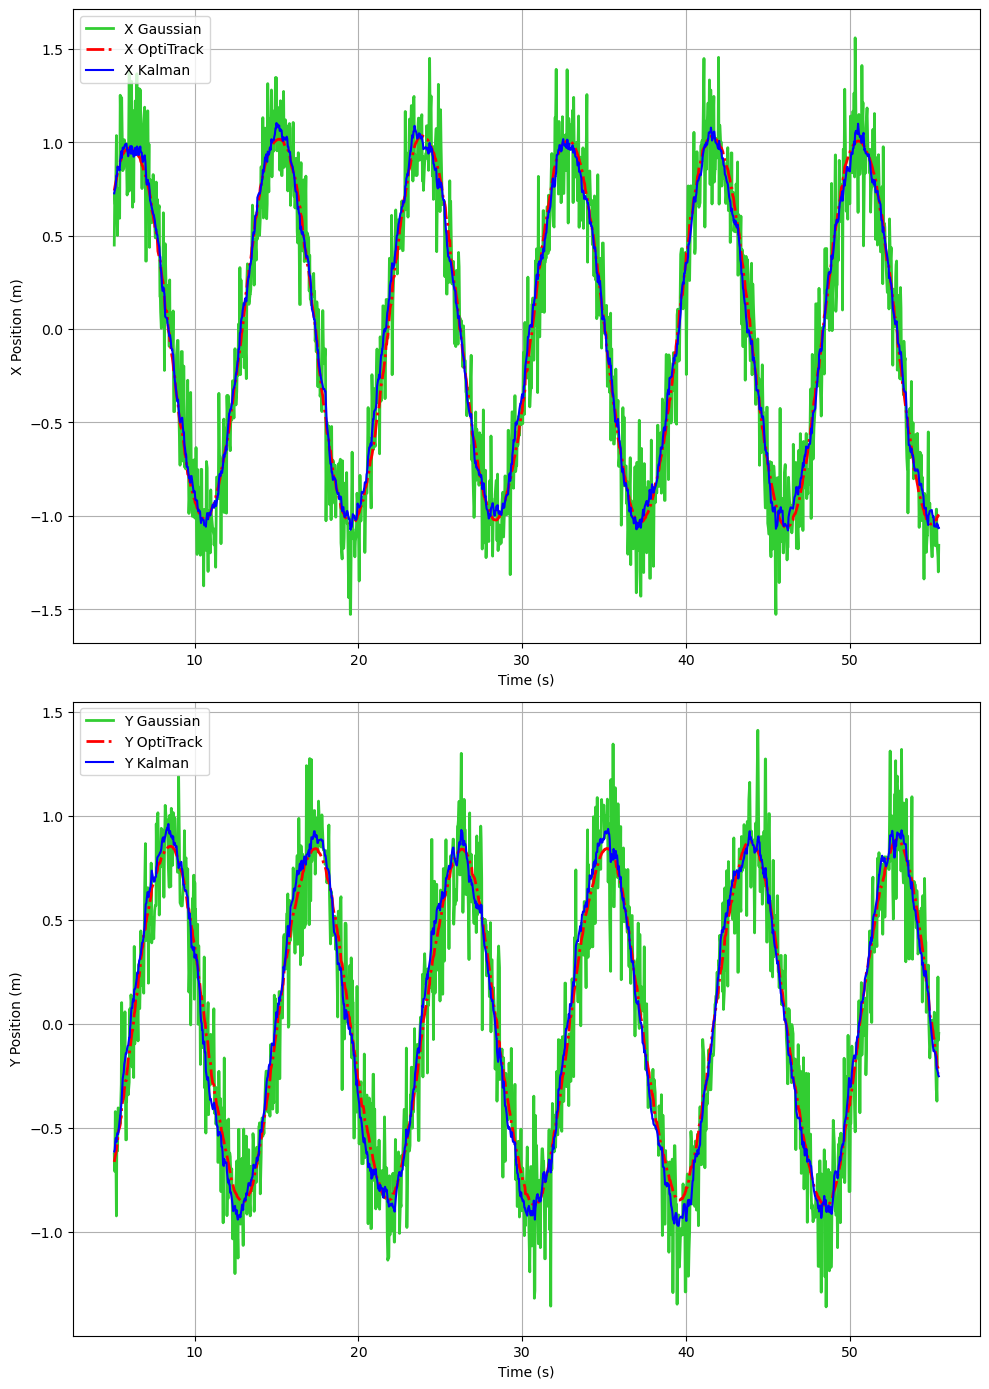

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(10, 14))

dimensions = ['X', 'Y']

for i in range(2):
    axs[i].plot(time, position_gaussian_error[:, i], label=f'{dimensions[i]} Gaussian', linestyle='-', color='limegreen', linewidth=2)
    axs[i].plot(time, position_optitrack[:, i], label=f'{dimensions[i]} OptiTrack', linestyle='-.', markersize=4, color='red', alpha=1, linewidth=2)
    axs[i].plot(time, position_kalman[:, i], label=f'{dimensions[i]} Kalman', linestyle='-', color='blue')

    # axs[i].set_title(f'Position Comparison: OptiTrack vs. Kalman vs. Gaussian Error ({dimensions[i]} Dimension)')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel(f'{dimensions[i]} Position (m)')
    axs[i].legend(loc='upper left')
    axs[i].grid(True)

# Adjust the layout so labels and titles do not overlap
plt.tight_layout()

if save_flag:
    vectorized_image_path = 'kalman_position_comparison.pdf'
    full_vectorized_image_path = os.path.join(save_image_path, vectorized_image_path)
    plt.savefig(full_vectorized_image_path, format='pdf')

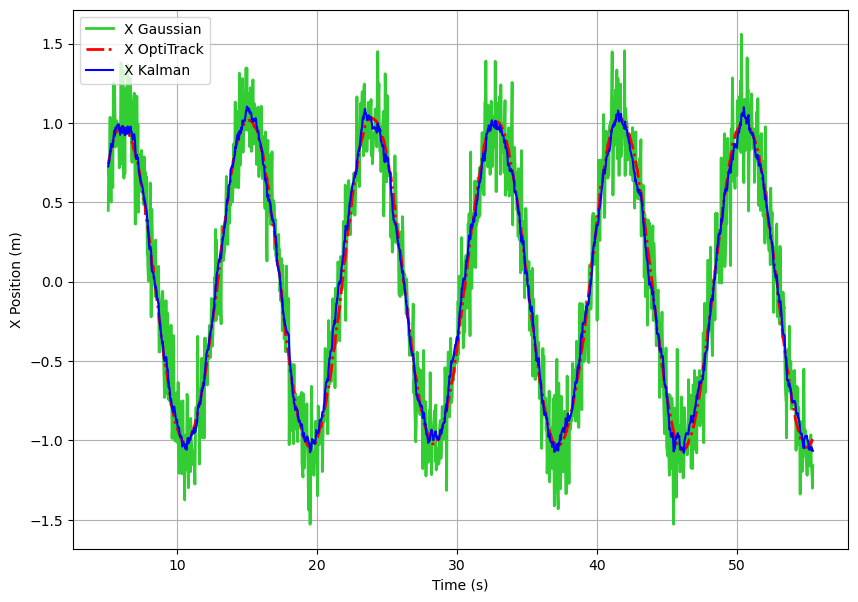

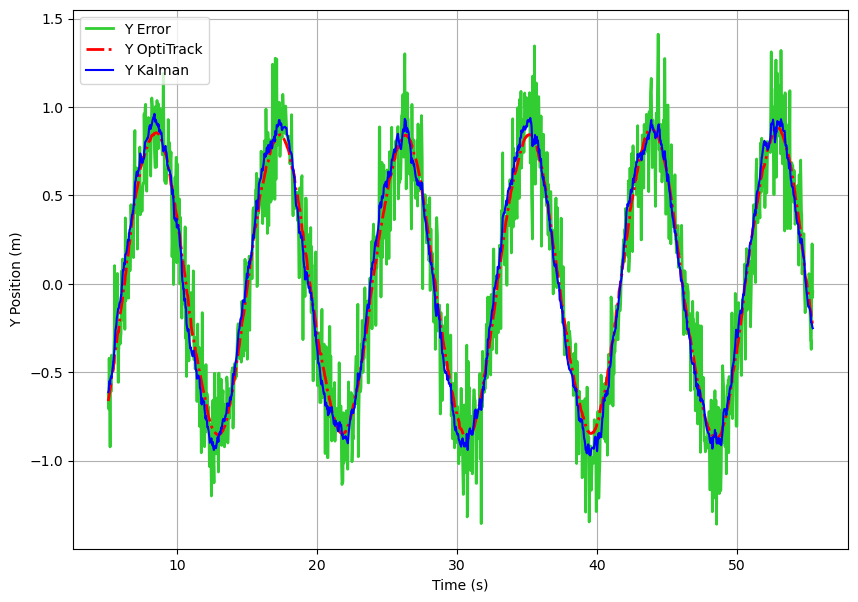

In [16]:
# Plotting Position Comparison: OptiTrack vs. Kalman vs. Gaussian Error (X Dimension)
plt.figure(figsize=(10, 7))
plt.plot(time, position_gaussian_error[:, 0], label='X Gaussian', linestyle='-', color='limegreen', linewidth=2)
plt.plot(time, position_optitrack[:, 0], label='X OptiTrack', linestyle='-.', markersize=4, color='red', alpha=1, linewidth=2)
plt.plot(time, position_kalman[:, 0], label='X Kalman', linestyle='-', color='blue')
# plt.title('Position Comparison: OptiTrack vs. Kalman vs. Gaussian Error (X Dimension)')
plt.xlabel('Time (s)')
plt.ylabel('X Position (m)')
plt.legend(loc='upper left')
plt.grid(True)
if save_flag:
    plt.savefig(os.path.join(save_image_path, 'kalman_position_comparison_X.pdf'), format='pdf')
plt.show()

# Plotting Position Comparison: OptiTrack vs. Kalman vs. Gaussian Error (Y Dimension)
plt.figure(figsize=(10, 7))
plt.plot(time, position_gaussian_error[:, 1], label='Y Error', linestyle='-', color='limegreen', linewidth=2)
plt.plot(time, position_optitrack[:, 1], label='Y OptiTrack', linestyle='-.', markersize=4, color='red', alpha=1, linewidth=2)
plt.plot(time, position_kalman[:, 1], label='Y Kalman', linestyle='-', color='blue')
# plt.title('Position Comparison: OptiTrack vs. Kalman vs. Gaussian Error (Y Dimension)')
plt.xlabel('Time (s)')
plt.ylabel('Y Position (m)')
plt.legend(loc='upper left')
plt.grid(True)
if save_flag:
    plt.savefig(os.path.join(save_image_path, 'kalman_position_comparison_Y.pdf'), format='pdf')
plt.show()


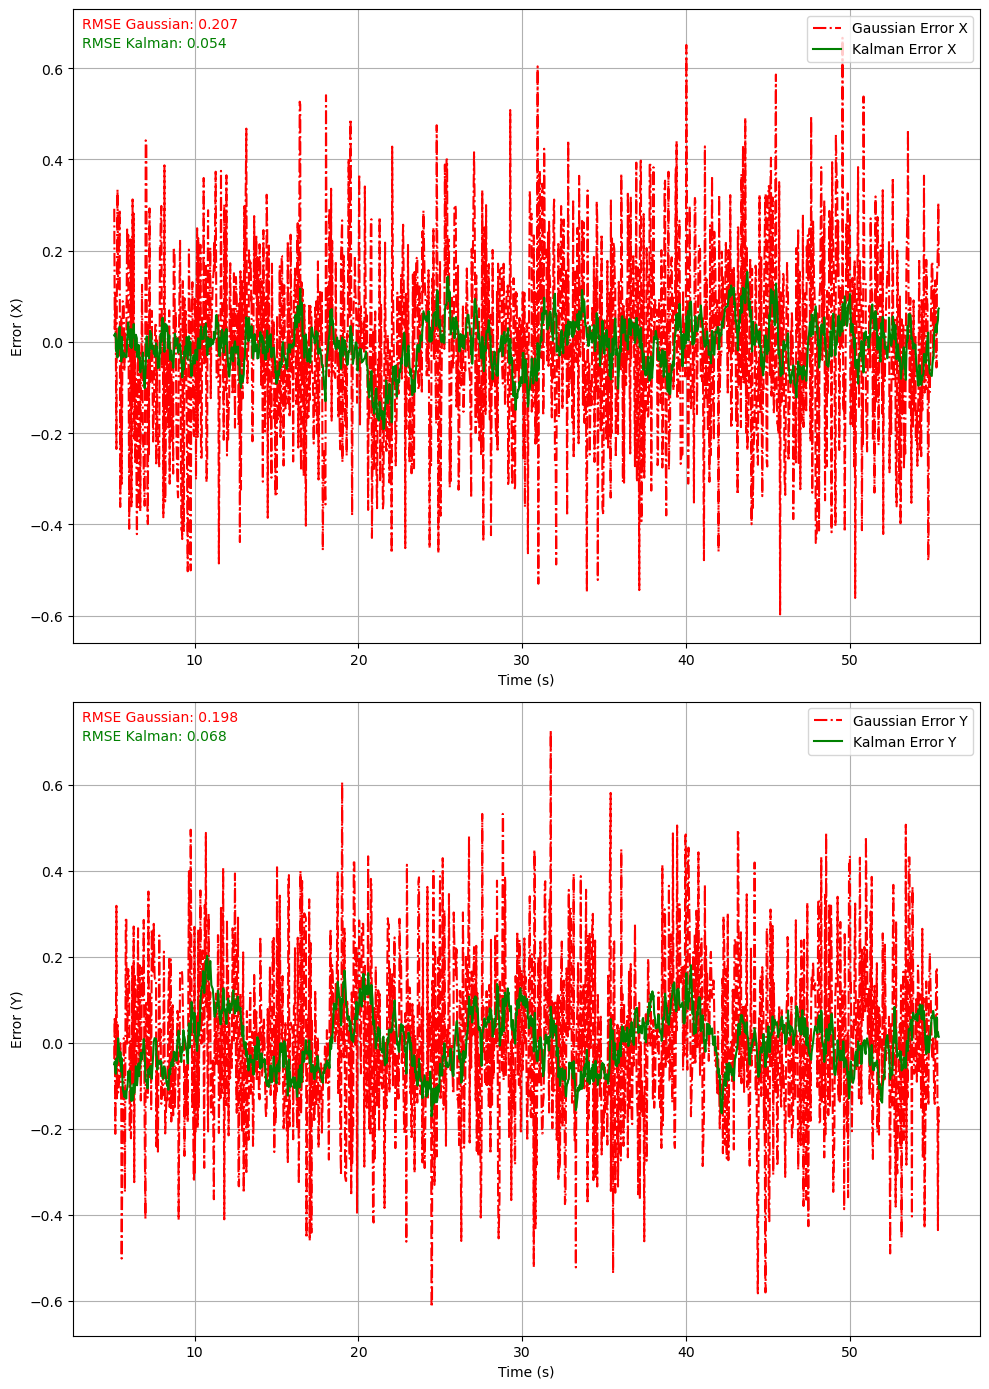

In [7]:
# Calculating errors
error_kalman = position_optitrack - position_kalman
gaussian_error = position_optitrack - position_gaussian_error

# Calculating RMSE for each dimension
rmse_kalman = [calculate_rmse(position_optitrack[:, i], position_kalman[:, i]) for i in range(3)]
rmse_optitrack = [calculate_rmse(position_optitrack[:, i], position_gaussian_error[:, i]) for i in range(3)]

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 14))  # 3 rows, 1 column for X, Y, Z dimensions

dimensions = ['X', 'Y']
for i in range(2):
    # Plotting the errors
    axs[i].plot(time, gaussian_error[:, i], label=f'Gaussian Error {dimensions[i]}', linestyle='-.', color='red')
    axs[i].plot(time, error_kalman[:, i], label=f'Kalman Error {dimensions[i]}', linestyle='-', color='green')
    
    # Annotating RMSE on the plot
    axs[i].annotate(f'RMSE Kalman: {rmse_kalman[i]:.3f}', xy=(0.01, 0.94), xycoords='axes fraction', fontsize=10, color='green')
    axs[i].annotate(f'RMSE Gaussian: {rmse_optitrack[i]:.3f}', xy=(0.01, 0.97), xycoords='axes fraction', fontsize=10, color='red')
    
    # axs[i].set_title(f'Error Comparison: Kalman and Gaussian vs. Optitrack ({dimensions[i]} Dimension)')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel(f'Error ({dimensions[i]})')
    axs[i].grid(True)
    
    # Adjusting the legend location
    axs[i].legend(loc='upper right')

# Adjust layout to not overlap the subplots
plt.tight_layout()

# Assuming save_flag and save_image_path are defined
if save_flag:
    plt.savefig(os.path.join(save_image_path, 'kalman_gaussian_error.pdf'), format='pdf')

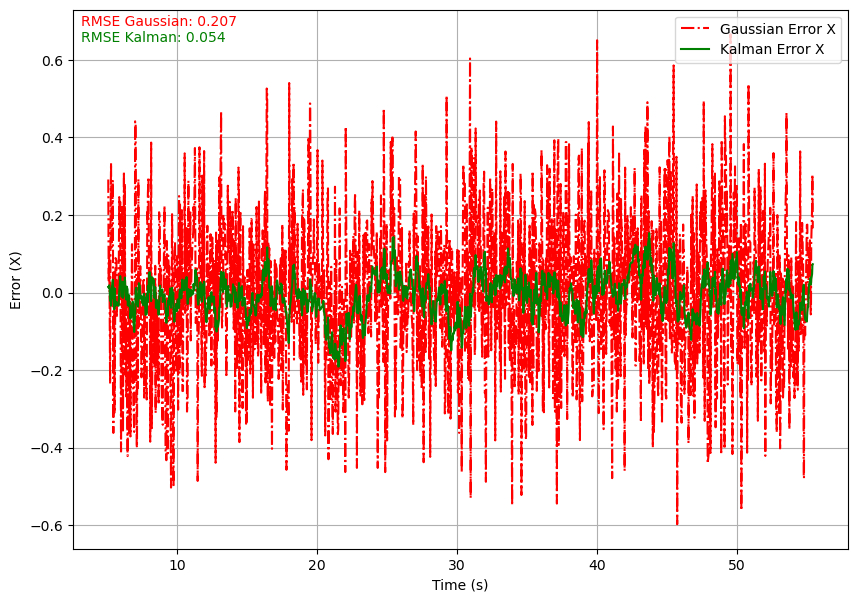

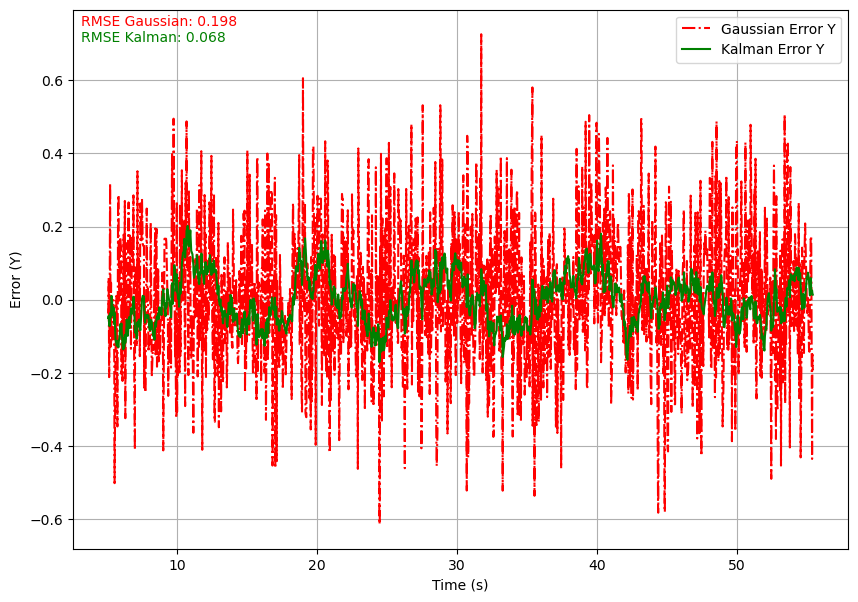

In [8]:
# Calculating errors
error_kalman = position_optitrack - position_kalman
gaussian_error = position_optitrack - position_gaussian_error

# Calculating RMSE for each dimension
rmse_kalman = [calculate_rmse(position_optitrack[:, i], position_kalman[:, i]) for i in range(3)]
rmse_optitrack = [calculate_rmse(position_optitrack[:, i], position_gaussian_error[:, i]) for i in range(3)]

# Plotting and saving the images separately
dimensions = ['X', 'Y']
for i in range(2):
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(time, gaussian_error[:, i], label=f'Gaussian Error {dimensions[i]}', linestyle='-.', color='red')
    ax.plot(time, error_kalman[:, i], label=f'Kalman Error {dimensions[i]}', linestyle='-', color='green')
    ax.annotate(f'RMSE Kalman: {rmse_kalman[i]:.3f}', xy=(0.01, 0.94), xycoords='axes fraction', fontsize=10, color='green')
    ax.annotate(f'RMSE Gaussian: {rmse_optitrack[i]:.3f}', xy=(0.01, 0.97), xycoords='axes fraction', fontsize=10, color='red')
    # ax.set_title(f'Error Comparison: Kalman and Gaussian vs. Optitrack ({dimensions[i]} Dimension)')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(f'Error ({dimensions[i]})')
    ax.grid(True)
    ax.legend(loc='upper right')
    if save_flag:
        plt.savefig(os.path.join(save_image_path, f'kalman_gaussian_error_{dimensions[i]}.pdf'), format='pdf')
    plt.show()


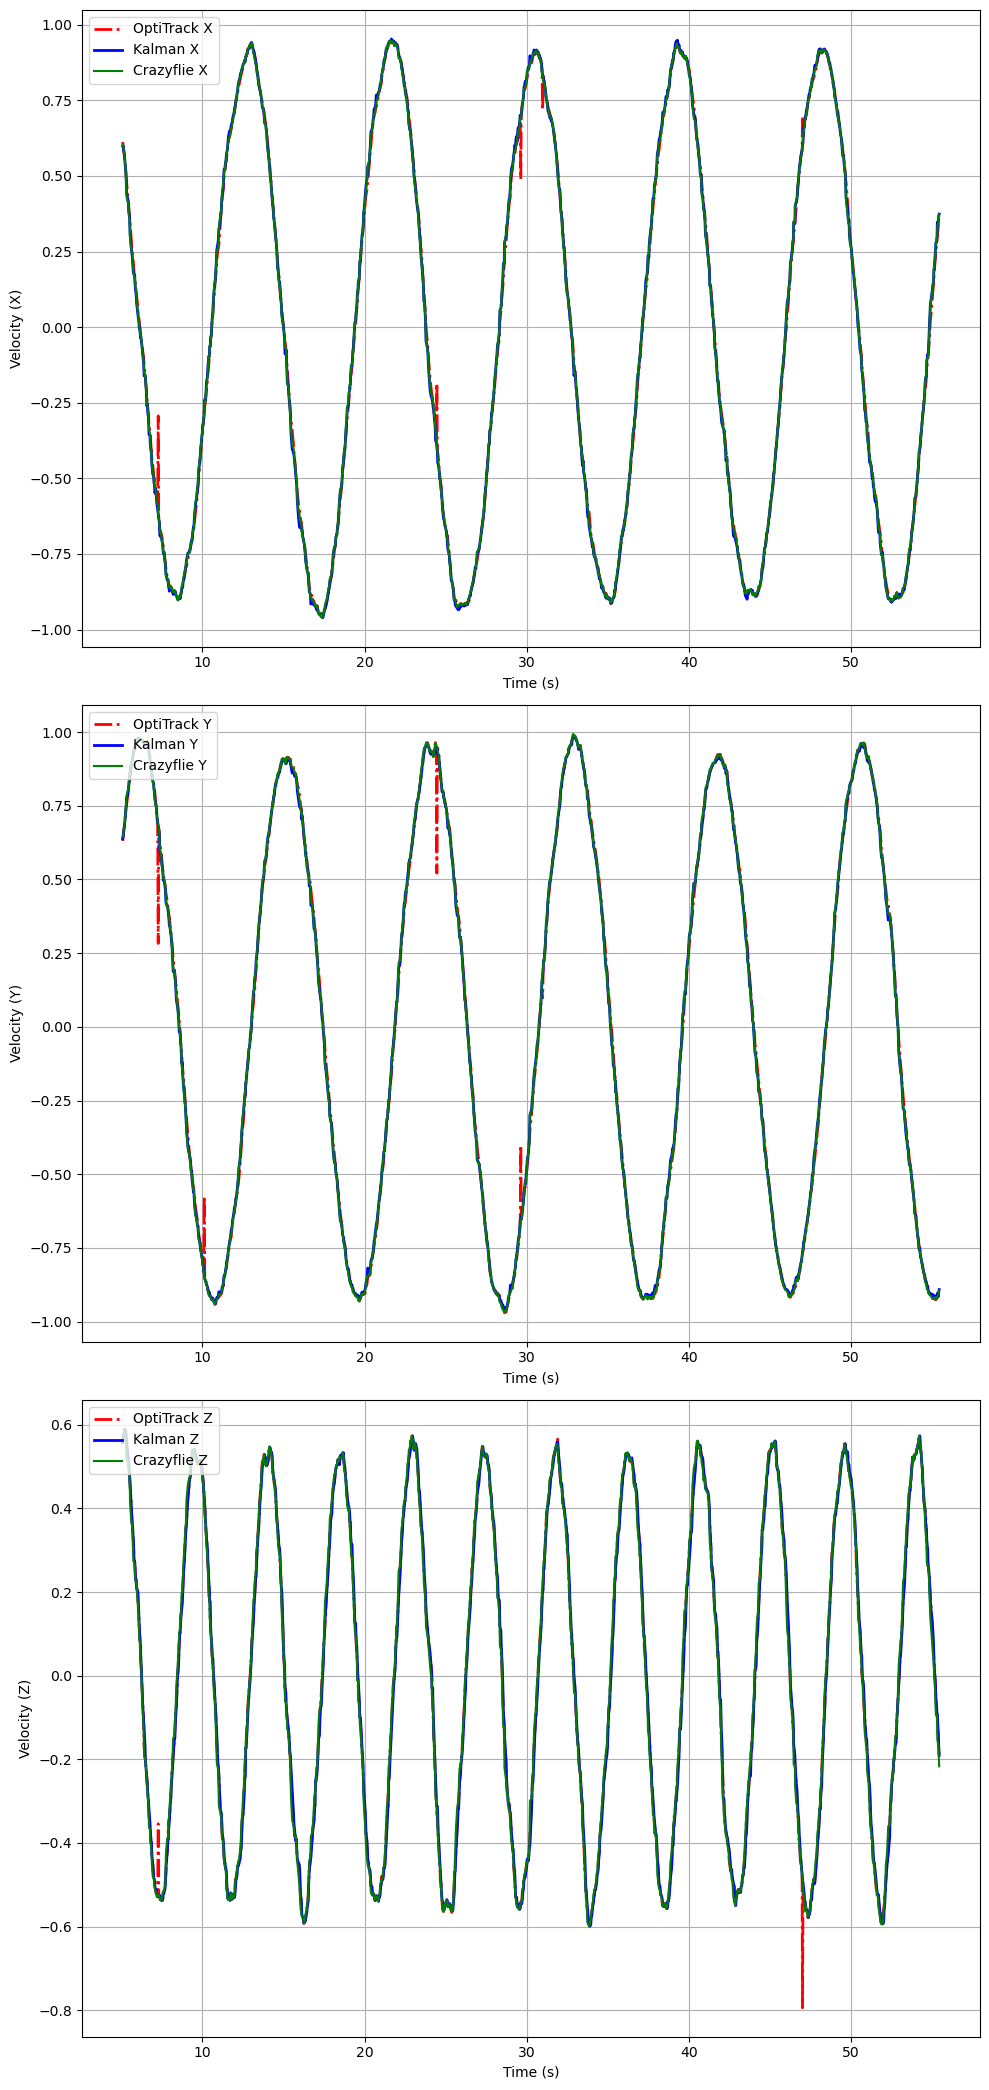

In [9]:
### Velocity Plots

fig, axs = plt.subplots(3 , 1, figsize=(10, 21))

dimensions = ['X', 'Y', 'Z']
for i in range(3):
    axs[i].plot(time, vel_optitrack_world[:, i], label=f'OptiTrack {dimensions[i]}', linestyle='-.', markersize=4, color='red', alpha=1, linewidth=2)
    axs[i].plot(time, vel_kalman_world[:, i], label=f'Kalman {dimensions[i]}', linestyle='-', color='blue', linewidth=2)
    axs[i].plot(time, vel_crazyflie_world[:, i], label=f'Crazyflie {dimensions[i]}', linestyle='-', color='green')

    # axs[i].set_title(f'Velocity Comparison: OptiTrack vs. Kalman vs. Crazyflie ({dimensions[i]} Dimension)')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel(f'Velocity ({dimensions[i]})')
    axs[i].legend(loc='upper left')
    axs[i].grid(True)

# Adjust the layout so labels and titles do not overlap
plt.tight_layout()

if save_flag:
    vectorized_image_path = 'kalman_velocity_comparison.pdf'
    full_vectorized_image_path = os.path.join(save_image_path, vectorized_image_path)
    plt.savefig(full_vectorized_image_path, format='pdf')

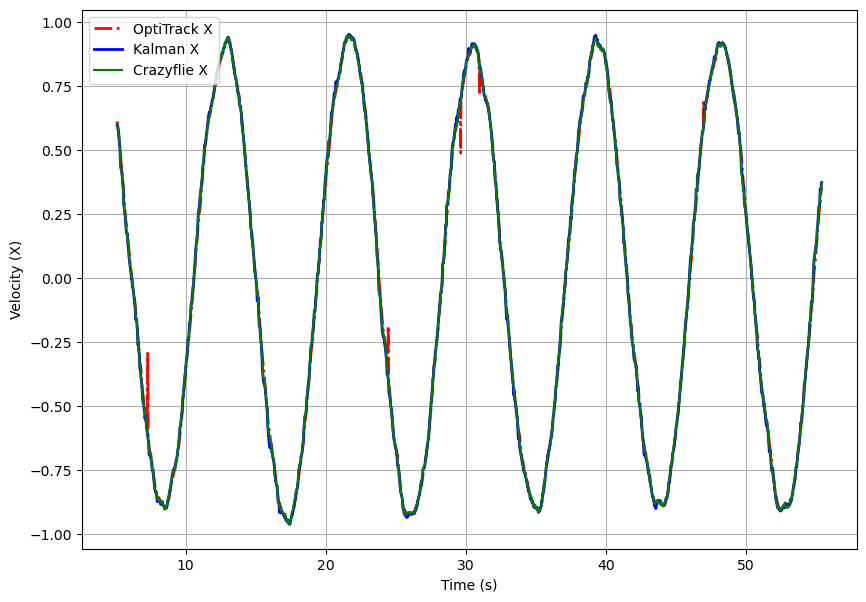

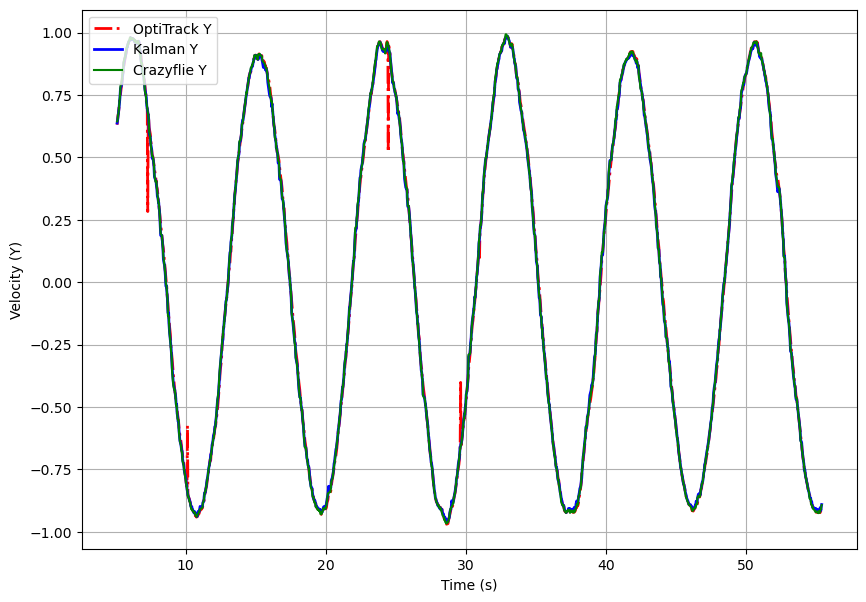

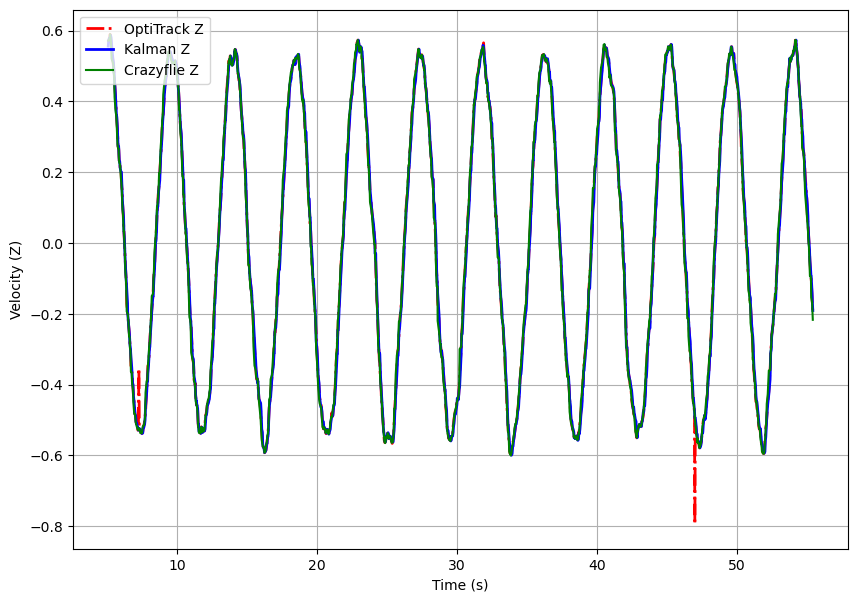

In [10]:
### Velocity Plots

dimensions = ['X', 'Y', 'Z']
for i in range(3):
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(time, vel_optitrack_world[:, i], label=f'OptiTrack {dimensions[i]}', linestyle='-.', markersize=4, color='red', alpha=1, linewidth=2)
    ax.plot(time, vel_kalman_world[:, i], label=f'Kalman {dimensions[i]}', linestyle='-', color='blue', linewidth=2)
    ax.plot(time, vel_crazyflie_world[:, i], label=f'Crazyflie {dimensions[i]}', linestyle='-', color='green')
    # ax.set_title(f'Velocity Comparison: OptiTrack vs. Kalman vs. Crazyflie ({dimensions[i]} Dimension)')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(f'Velocity ({dimensions[i]})')
    ax.legend(loc='upper left')
    ax.grid(True)
    if save_flag:
        plt.savefig(os.path.join(save_image_path, f'kalman_velocity_comparison_{dimensions[i]}.pdf'), format='pdf')
    plt.show()


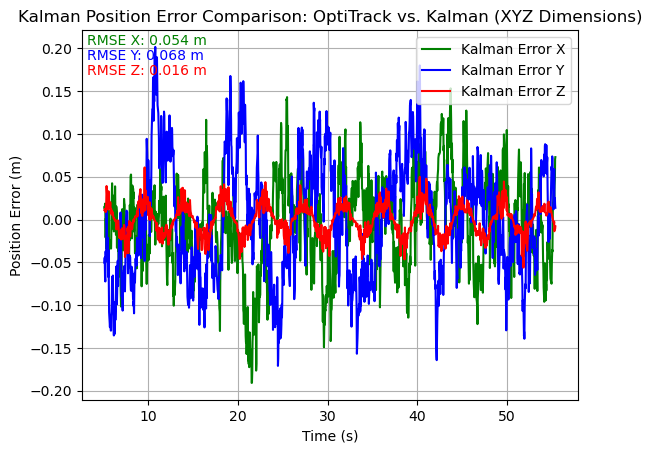

In [18]:
### Position error plot

# Plotting the error
plt.plot(time, error_kalman[:, 0], label='Kalman Error X', linestyle='-', color='green')
plt.plot(time, error_kalman[:, 1], label='Kalman Error Y', linestyle='-', color='blue')
plt.plot(time, error_kalman[:, 2], label='Kalman Error Z', linestyle='-', color='red')

# Annotating RMSE on the plot
plt.annotate(f'RMSE X: {rmse_kalman[0]:.3f} m', xy=(0.01, 0.96), xycoords='axes fraction', fontsize=10, color='green')
plt.annotate(f'RMSE Y: {rmse_kalman[1]:.3f} m', xy=(0.01, 0.92), xycoords='axes fraction', fontsize=10, color='blue')
plt.annotate(f'RMSE Z: {rmse_kalman[2]:.3f} m ', xy=(0.01, 0.88), xycoords='axes fraction', fontsize=10, color='red')

# Setting the title and labels
plt.title('Kalman Position Error Comparison: OptiTrack vs. Kalman (XYZ Dimensions)')
plt.xlabel('Time (s)')
plt.ylabel('Position Error (m)')
plt.grid(True)
plt.legend(loc='upper right')

if save_flag:
    plt.savefig(os.path.join(save_image_path, 'kalman_position_error_xyz.pdf'), format='pdf')

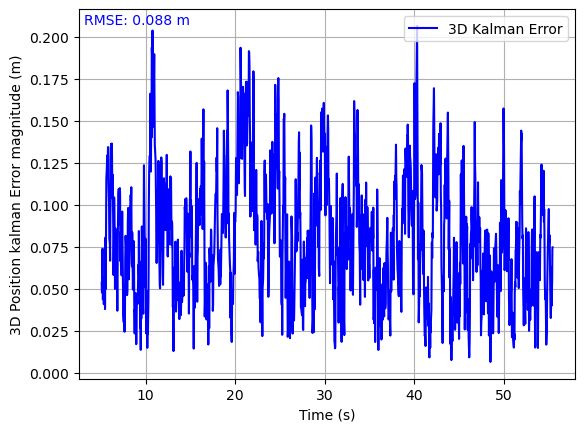

In [19]:
### 3D kalman error
# calculating 3d error
error_kalman = position_optitrack - position_kalman
error_kalman_3d = np.linalg.norm(error_kalman, axis=1)

# Calculate RMSE manually
rmse_kalman_3d = np.sqrt(np.mean(error_kalman_3d ** 2))

# Plotting the error
plt.plot(time, error_kalman_3d, label='3D Kalman Error', linestyle='-', color='b')

# Annotating RMSE on the plot
plt.annotate(f'RMSE: {rmse_kalman_3d:.3f} m', xy=(0.01, 0.96), xycoords='axes fraction', fontsize=10, color='b')

# Setting the title and labels
# plt.title('3D Kalman Position Error Comparison: OptiTrack vs. Kalman (m)')
plt.xlabel('Time (s)')
plt.ylabel('3D Position kalman Error magnitude (m)')
plt.grid(True)
plt.legend(loc='upper right')

if save_flag:
    plt.savefig(os.path.join(save_image_path, 'kalman_position_error_3d.pdf'), format='pdf')

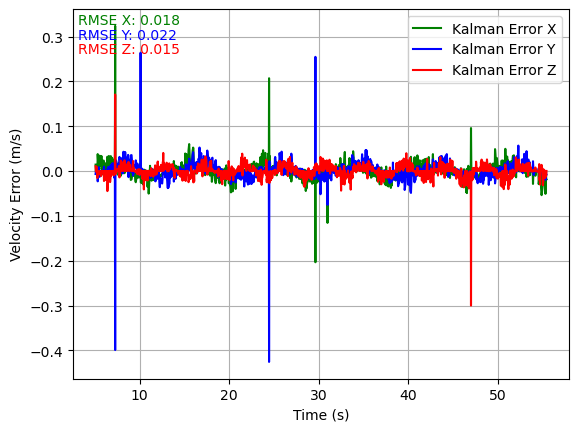

In [21]:
### Velocity error plot

# Calculate velocity errors
error_vel_kalman = vel_optitrack_world - vel_kalman_world

# Plotting the error
plt.plot(time, error_vel_kalman[:, 0], label='Kalman Error X', linestyle='-', color='green')
plt.plot(time, error_vel_kalman[:, 1], label='Kalman Error Y', linestyle='-', color='blue')
plt.plot(time, error_vel_kalman[:, 2], label='Kalman Error Z', linestyle='-', color='red')

# Calculating RMSE for each dimension
# rmse_vel_kalman = [calculate_rmse(vel_optitrack_world[:, i], vel_kalman_world[:, i]) for i in range(3)]

# Calculating RMSE for each dimension manulally
rmse_kalman_x = np.sqrt(np.mean(error_vel_kalman[:, 0] ** 2))
rmse_kalman_y = np.sqrt(np.mean(error_vel_kalman[:, 1] ** 2))
rmse_kalman_z = np.sqrt(np.mean(error_vel_kalman[:, 2] ** 2))
rmse_vel_kalman = [rmse_kalman_x, rmse_kalman_y, rmse_kalman_z]

plt.annotate(f'RMSE X: {rmse_vel_kalman[0]:.3f}', xy=(0.01, 0.96), xycoords='axes fraction', fontsize=10, color='green')
plt.annotate(f'RMSE Y: {rmse_vel_kalman[1]:.3f}', xy=(0.01, 0.92), xycoords='axes fraction', fontsize=10, color='blue')
plt.annotate(f'RMSE Z: {rmse_vel_kalman[2]:.3f}', xy=(0.01, 0.88), xycoords='axes fraction', fontsize=10, color='red')

# Setting the title and labels
# plt.title('Kalman Velocity Error Comparison: OptiTrack vs. Kalman (XYZ Dimensions)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity Error (m/s)')
plt.grid(True)
plt.legend(loc='upper right')

if save_flag:
    plt.savefig(os.path.join(save_image_path, 'kalman_velocity_error_xyz.pdf'), format='pdf')

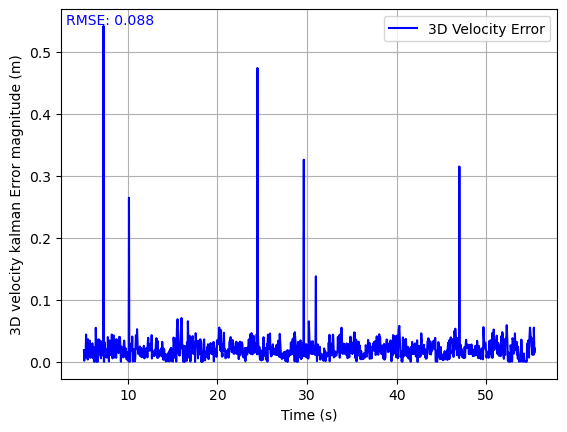

In [20]:
### 3D velocity 3D kalman error
vel_error_kalman = np.linalg.norm(vel_optitrack_world - vel_kalman_world, axis=1)

# Calculate RMSE manually
rmse_vel_kalman = np.sqrt(np.mean(vel_error_kalman ** 2))

# Plotting the error
plt.plot(time, vel_error_kalman, label='3D Velocity Error', linestyle='-', color='b')

# Annotating RMSE on the plot
plt.annotate(f'RMSE: {rmse_kalman_3d:.3f}', xy=(0.01, 0.96), xycoords='axes fraction', fontsize=10, color='b')

# Setting the title and labels
plt.xlabel('Time (s)')
plt.ylabel('3D velocity kalman Error magnitude (m)')
plt.grid(True)
plt.legend(loc='upper right')

if save_flag:
    plt.savefig(os.path.join(save_image_path, 'kalman_velocity_error_3d.pdf'), format='pdf')